# Calibrate the holograms using Halpha filter
==================================================================================================

- author : Jérémy Neveu
- date   : May 31st 2017


In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

FindCentralStar
ccdproc version 1.2.0
bottleneck version 1.2.0
/Users/jneveu/Documents/LSST/Calibration/CTIOAnaJun2017/ana_31may17/FocusHalpha


### Input directory

In [3]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=51
MAX_IMGNUMBER=55
object_name='HD111980'
SelectTagRe='^trim_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170531_[0-9]+.fits$'
NBIMGPERLROW=4

### Output directories

In [4]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./cut_fitsimages"
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [5]:
dirlist_all = [inputdir]
sorted_numbers,sorted_files = MakeFileList(dirlist_all,MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


### Show images

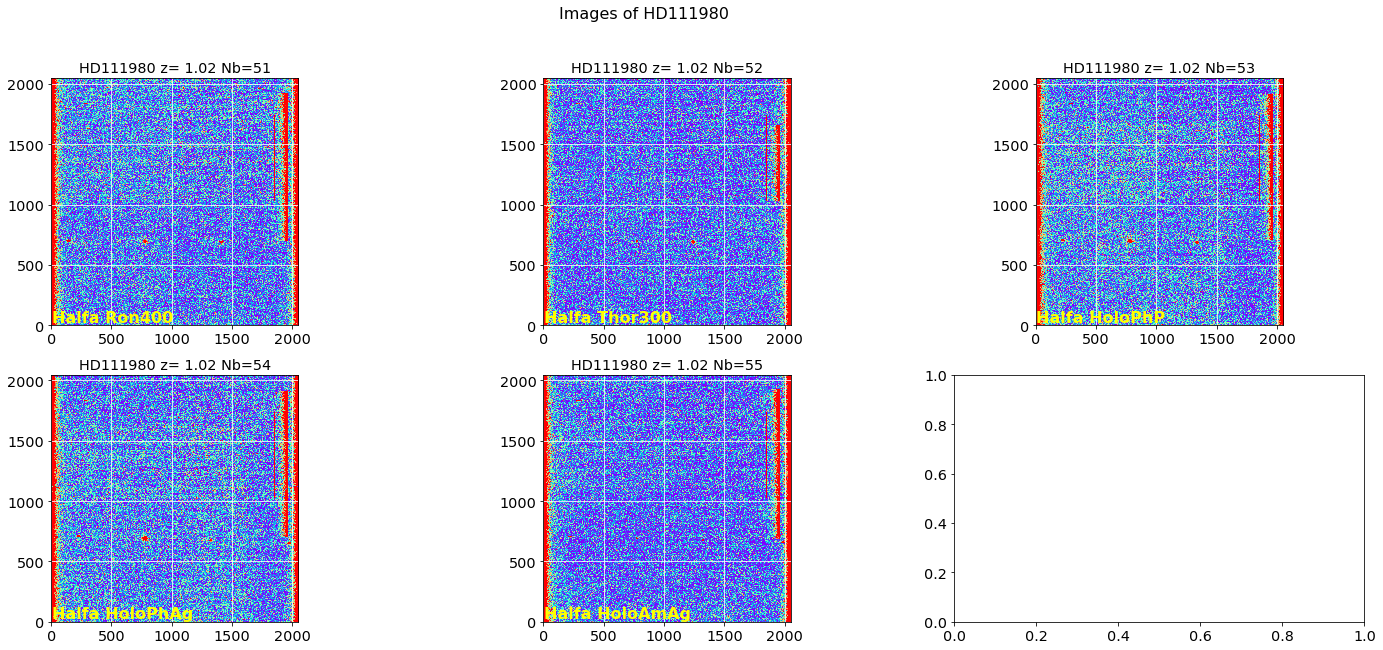

In [6]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERLROW=3,vmin=0,vmax=20)

figfilename=os.path.join(dir_top_images,'input_images.pdf')
plt.savefig(figfilename)   

### Show histograms

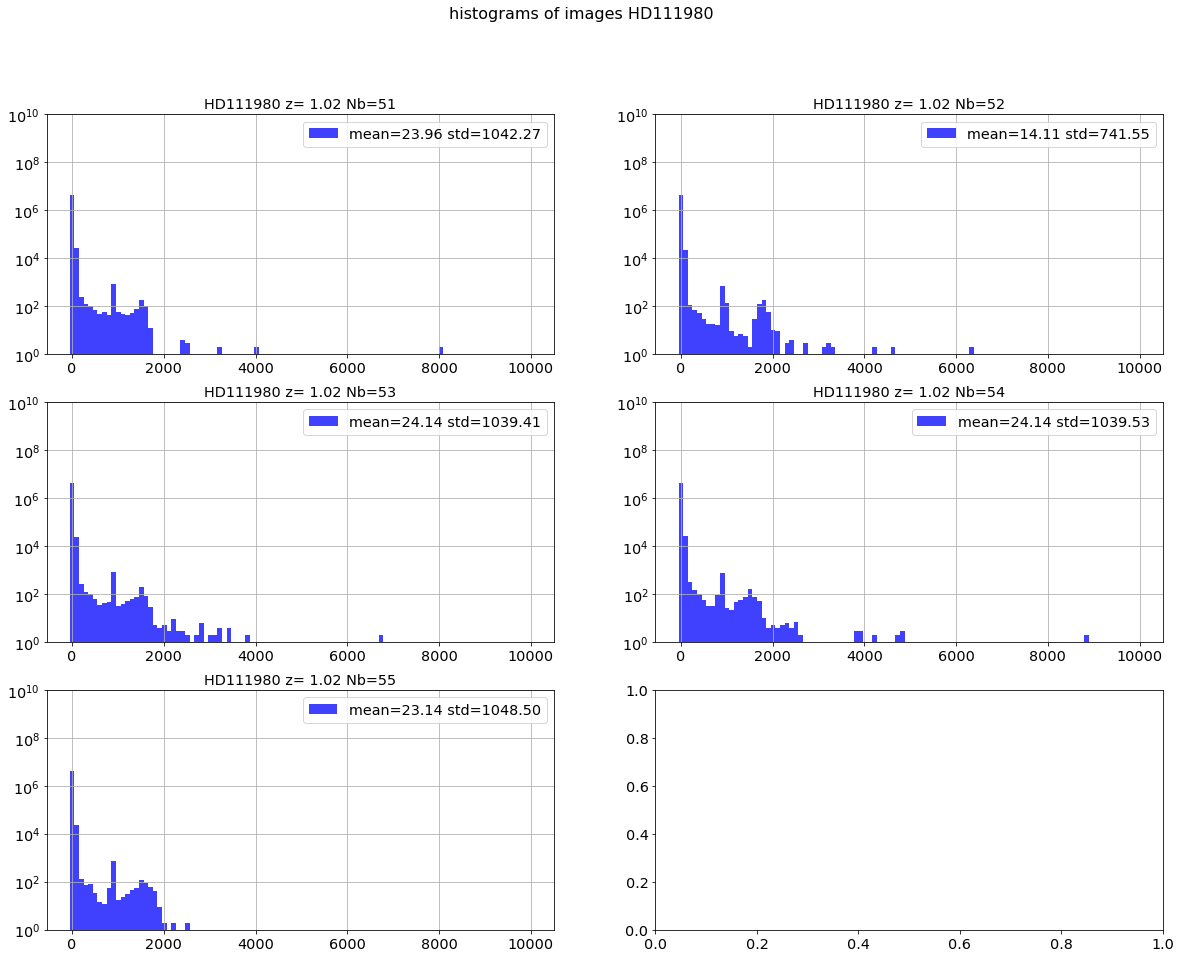

In [7]:
ShowHistograms(all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,bins=100,range=(-50,10000))

# Find the star locations
======================================

### Cut the image

To help the source finding algorthim.

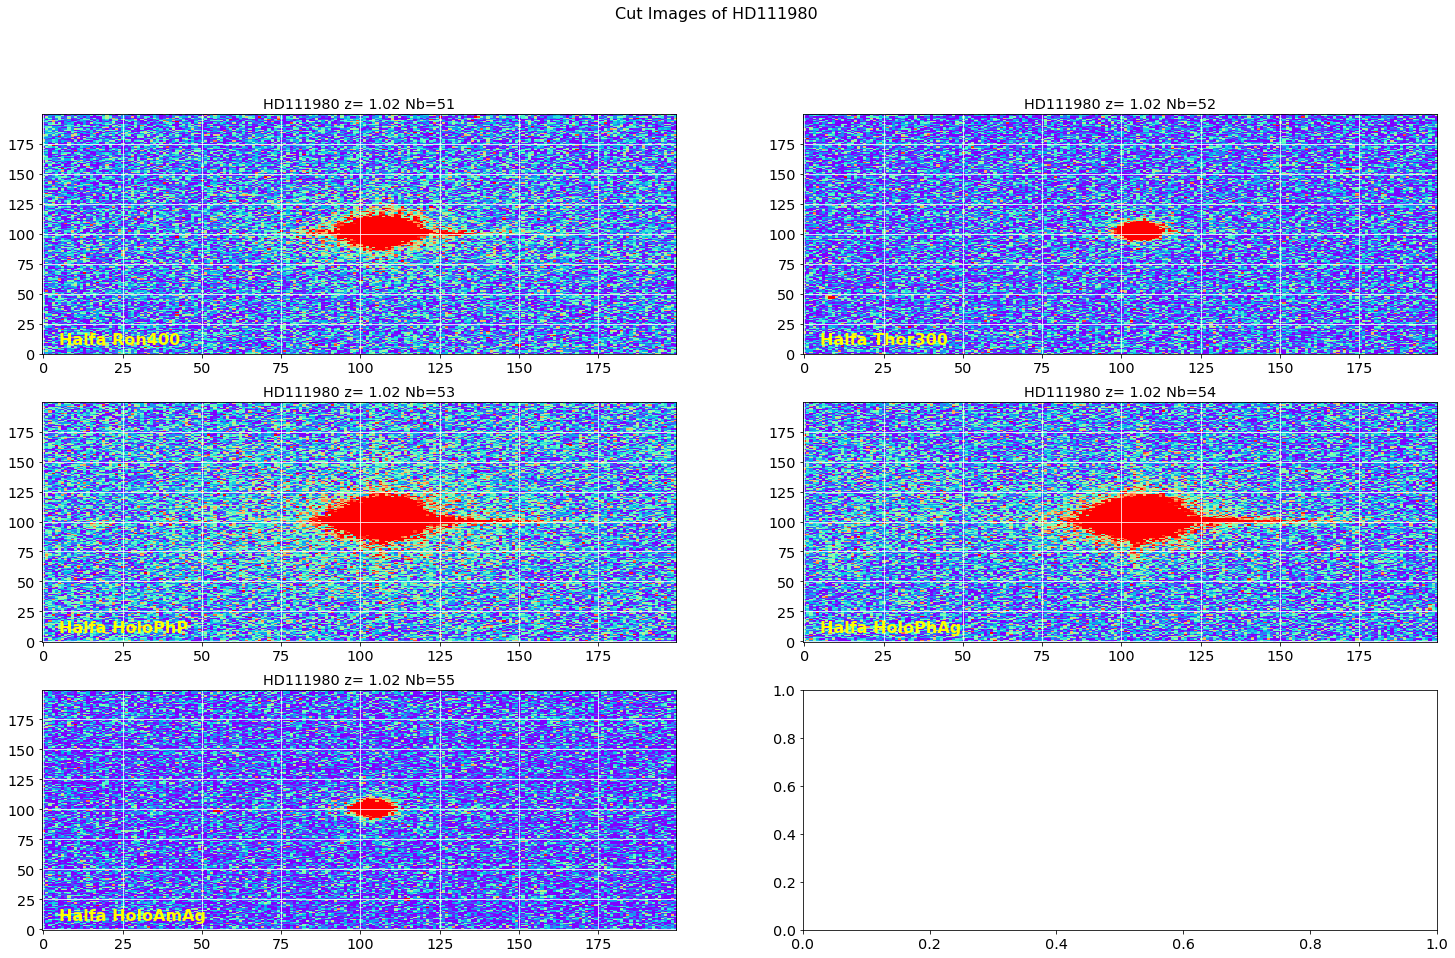

In [8]:
x_guess = 770
y_guess = 690
DeltaY=100
DeltaX=100

images_cut=ShowCenterImages(x_guess,y_guess,DeltaX,DeltaY,all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=20)
figfilename=os.path.join(dir_top_images,'cut_images.pdf')
plt.savefig(figfilename)   

In [9]:
# (JN) valeurs optimisées pour cette étude
img_mean,img_median,img_std,img_sources=ComputeStatImages(images_cut,fwhm=5,threshold=10,sigma=10.0,iters=5)

----------------------------------------------------------------
0  mean, median, std =  4.48833874255 4.0 6.28392740278
 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 106.147190921 100.560519234 ... 17153.0 392.963518672 -6.48588058475
----------------------------------------------------------------
1  mean, median, std =  3.14162154031 3.0 5.49172284017
 id   xcentroid     ycentroid   ...  peak       flux          mag      
--- ------------- ------------- ... ------ ------------- --------------
  1 105.550789181 101.884057655 ... 2691.0 68.0247415013 -4.58166725026
----------------------------------------------------------------
2  mean, median, std =  6.35359951603 6.0 7.69981802841
 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 105.694954231 100.594477128 ... 50340.0 959.69930341

        Use DAOStarFinder instead. [astropy.utils.decorators]


### Central star position

[[ 776.14719092  690.56051923]
 [ 775.55078918  691.88405765]
 [ 775.69495423  690.59447713]
 [ 774.49808599  690.60961138]
 [ 773.60054392  690.78199706]]


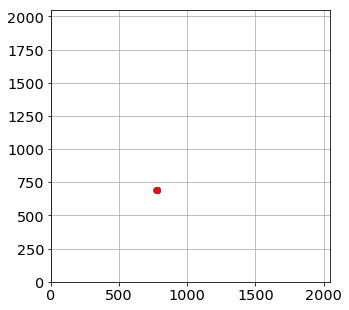

In [10]:
x_star = []
y_star = []
for s in img_sources:
    for ss in s:
        x_star.append(ss['xcentroid']+x_guess-DeltaX)
        y_star.append(ss['ycentroid']+y_guess-DeltaY)
        
positions_central = np.array([x_star,y_star]).T
print positions_central

x_mean = np.mean(x_star)
y_mean = np.mean(y_star)
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x_mean,y_mean,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

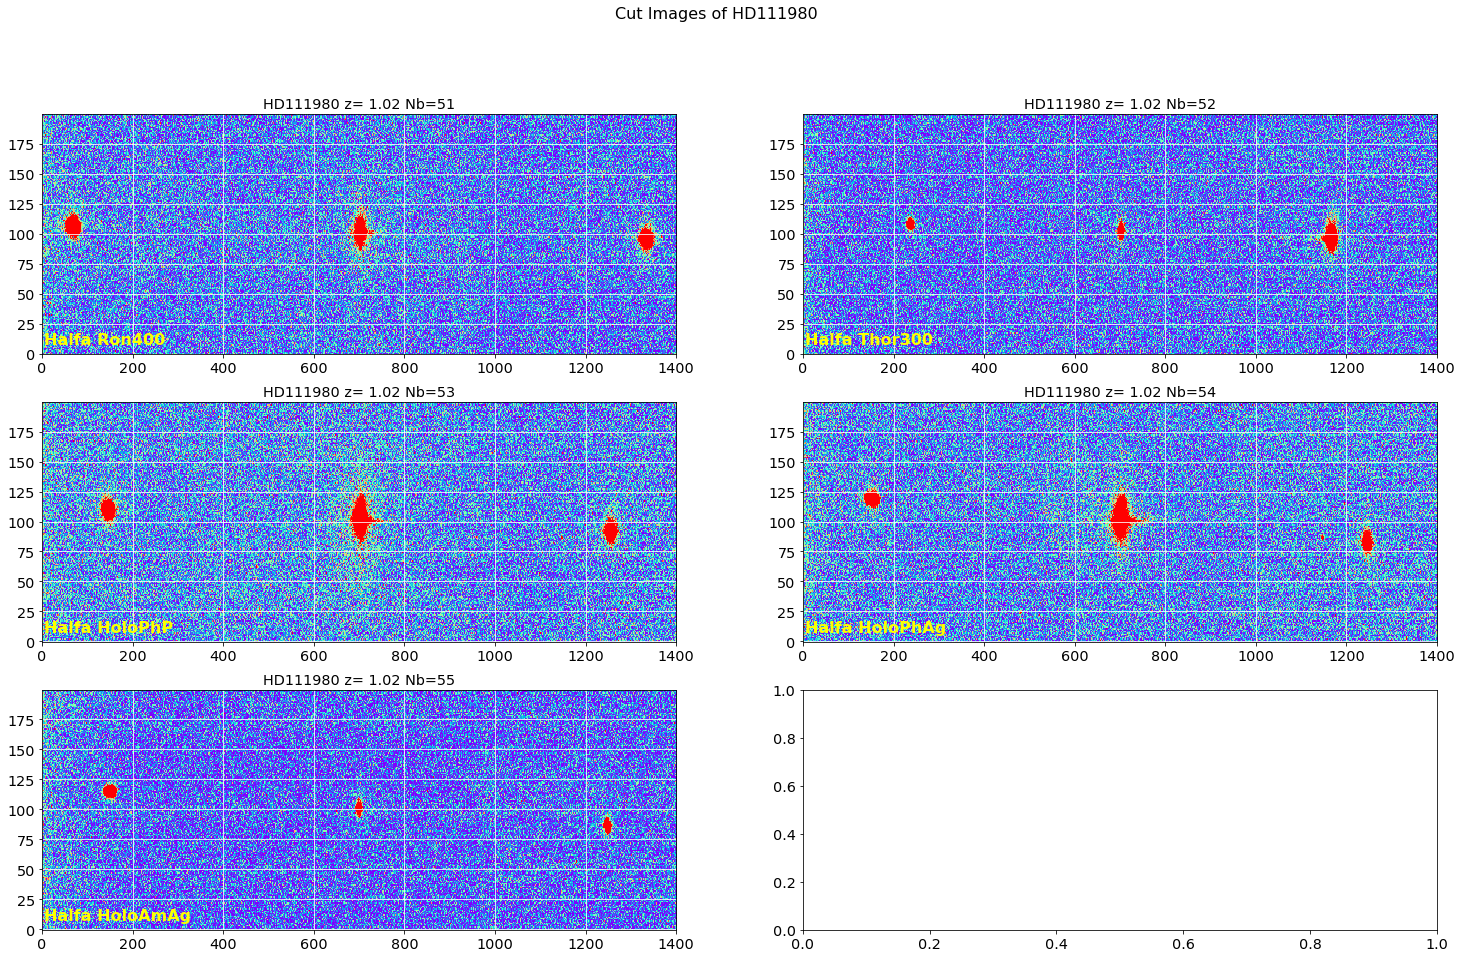

In [11]:
DeltaX = 700
DeltaY = 100
images_cut=ShowCenterImages(int(x_mean),int(y_mean),DeltaX,DeltaY,all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=20)
figfilename=os.path.join(dir_top_images,'cut_images.pdf')
plt.savefig(figfilename) 

### Save cut images and star centers

In [12]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

trim_20170531_051.fits
trim_20170531_052.fits
trim_20170531_053.fits
trim_20170531_054.fits
trim_20170531_055.fits


In [13]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  2252160 26 jul 13:14 cut_fitsimages/cutimg_20170531_051.fits
-rw-r--r--  1 jneveu  staff  2252160 26 jul 13:14 cut_fitsimages/cutimg_20170531_052.fits
-rw-r--r--  1 jneveu  staff  2252160 26 jul 13:14 cut_fitsimages/cutimg_20170531_053.fits
-rw-r--r--  1 jneveu  staff  2252160 26 jul 13:14 cut_fitsimages/cutimg_20170531_054.fits
-rw-r--r--  1 jneveu  staff  2252160 26 jul 13:14 cut_fitsimages/cutimg_20170531_055.fits
-rw-r--r--  1 jneveu  staff       56 26 jul 08:55 cut_fitsimages/star_centroids.txt


In [14]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

./cut_fitsimages/star_centroids.txt


# Find the optimal rotation of the spectra
============================

In [15]:
inputdir="./cut_fitsimages"
SelectTagRe='^cutimg_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^cutimg_20170531_[0-9]+.fits$'

outputdir="./rotated_fitsimages"
ensure_dir(outputdir)

In [16]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


### New star positions

In [17]:
thex0 = np.rint(np.array(x_star)).astype(int) - int(x_mean) + DeltaX
they0 = np.rint(np.array(y_star)).astype(int) - int(y_mean) + DeltaY
print thex0
print they0

[701 701 701 699 699]
[101 102 101 101 101]


### Subtract background

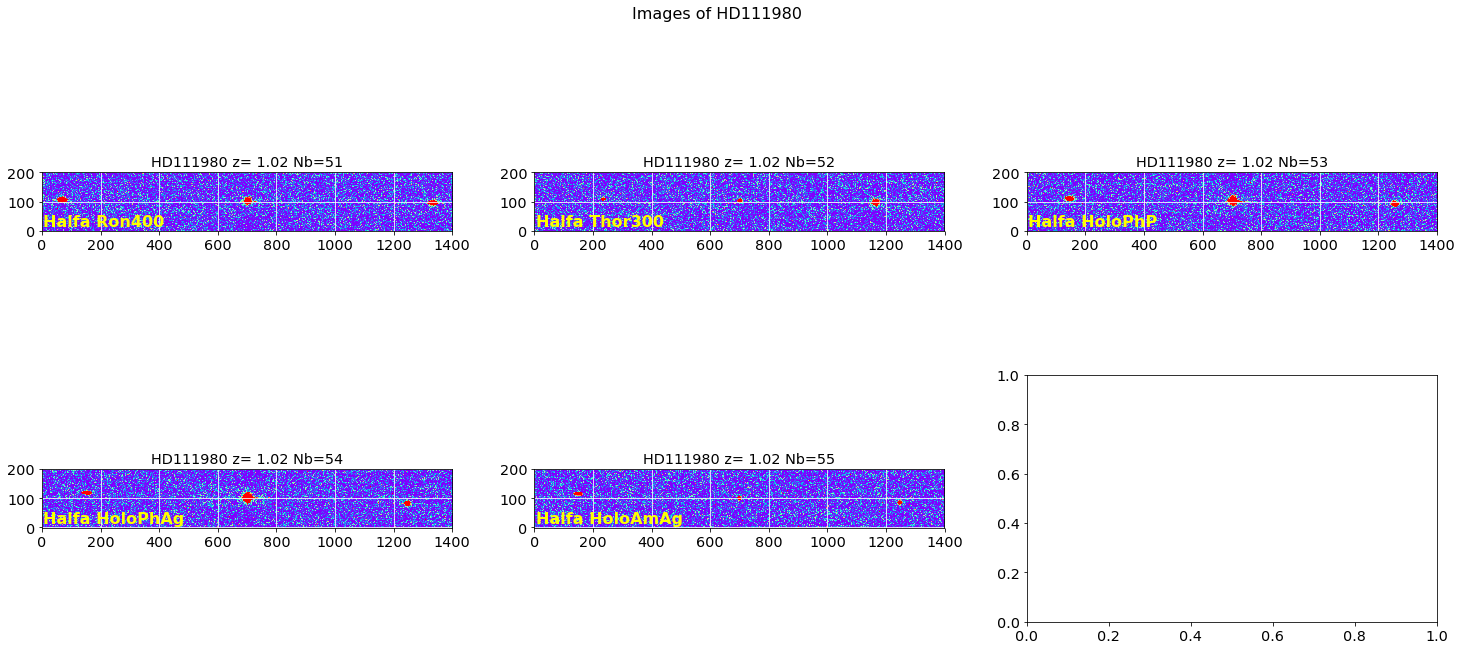

In [18]:
all_images2=[]
for image in all_images:
    image_copy=np.copy(image)
    all_images2.append(image_copy)

for theimage in all_images2:
    NR,NC=theimage.shape
    EmptySkyBackground=np.zeros([NR,NC])
    SkyBackground=EmptySkyBackground+np.median(theimage,axis=0)
    theimage-=SkyBackground
    
ShowImages(all_images2,all_titles,all_filt,object_name,NBIMGPERLROW=3,vmin=0,vmax=20)

## Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

### Test rotation optimal settings

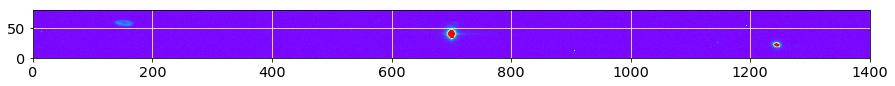

In [19]:
sel=3
image_sel=np.copy(all_images2[sel])
y0=int(they0[sel])
x0=int(thex0[sel])

width_cut = 40
right_edge = 1600

plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

region=np.copy(image_sel[y0-width_cut:y0+width_cut,0:right_edge])
data=np.copy(region)
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

In [20]:
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi

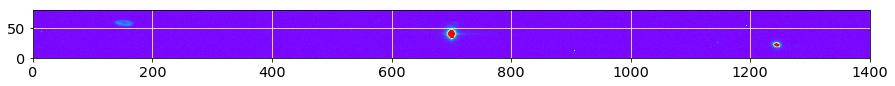

In [21]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Number of remaining pixels : 701


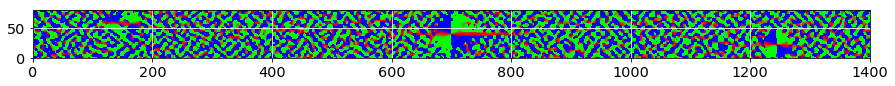

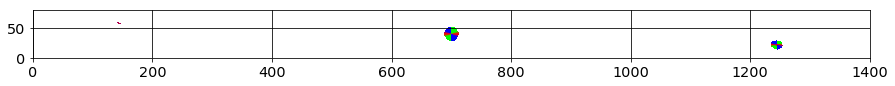

In [22]:
lambda_threshold = -5

mask = np.where(lambda_minus>lambda_threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan

theta_mask = np.copy(theta)
theta_mask[mask]=np.nan

print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])

plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

plt.imshow(theta,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()

plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

In [23]:
deg_threshold = 20

mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Number of remaining pixels : 175


Angle median : -3.20831771983


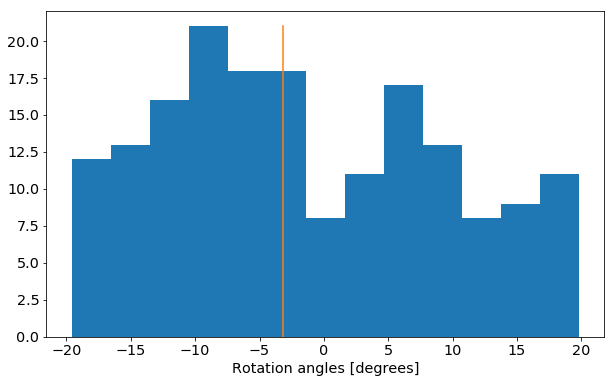

In [24]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

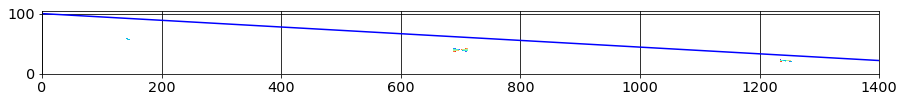

In [25]:
xindex=np.arange(data.shape[1])
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 - width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -1.89340622342


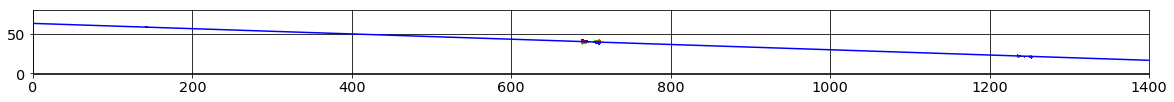

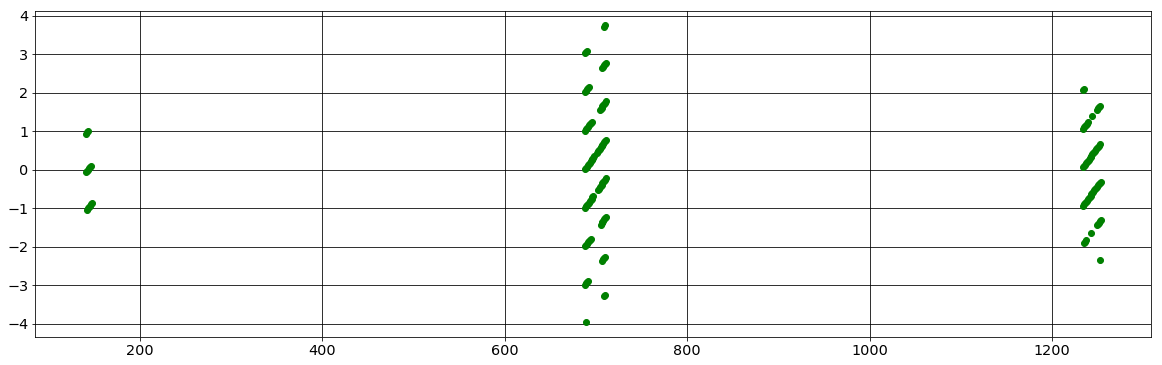

In [26]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>deg_threshold : continue
            xtofit.append(ix)
            ytofit.append(iy)
popt, pcov = fit_line(xtofit, ytofit)
[a, b] = popt
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = line(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,6])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
fig = plt.figure(figsize=[20,6])
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-line(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

0  theta =  -0.466596089066
1  theta =  -0.747273407473
2  theta =  -0.931313848932
3  theta =  -1.89340622342
4  theta =  -1.50089666359


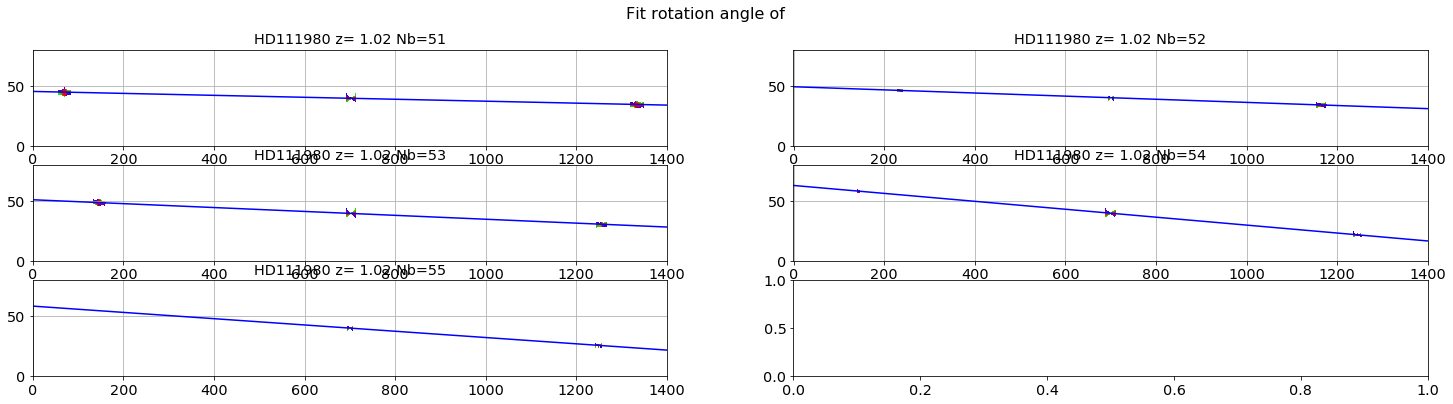

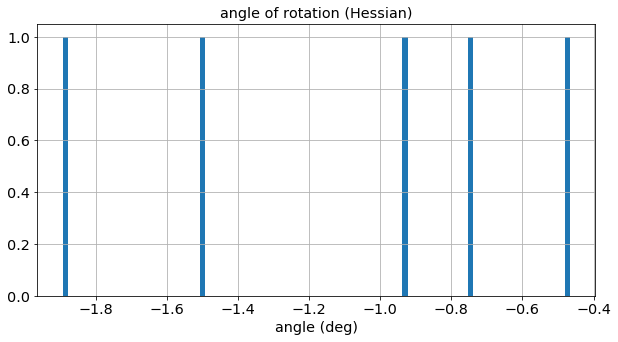

In [27]:
all_theta=ComputeRotationAngleHessianAndFit(all_images2,thex0,they0,all_titles,object_name, 
            NBIMGPERROW=2, lambda_threshold = -5, deg_threshold = 20, width_cut = 40, right_edge = 1600)
figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
plt.savefig(figfilename)  

for index in range(len(all_theta)):
    print index,' theta = ',all_theta[index]
plt.figure(figsize=(10,5))
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

### Turn the images accordingly

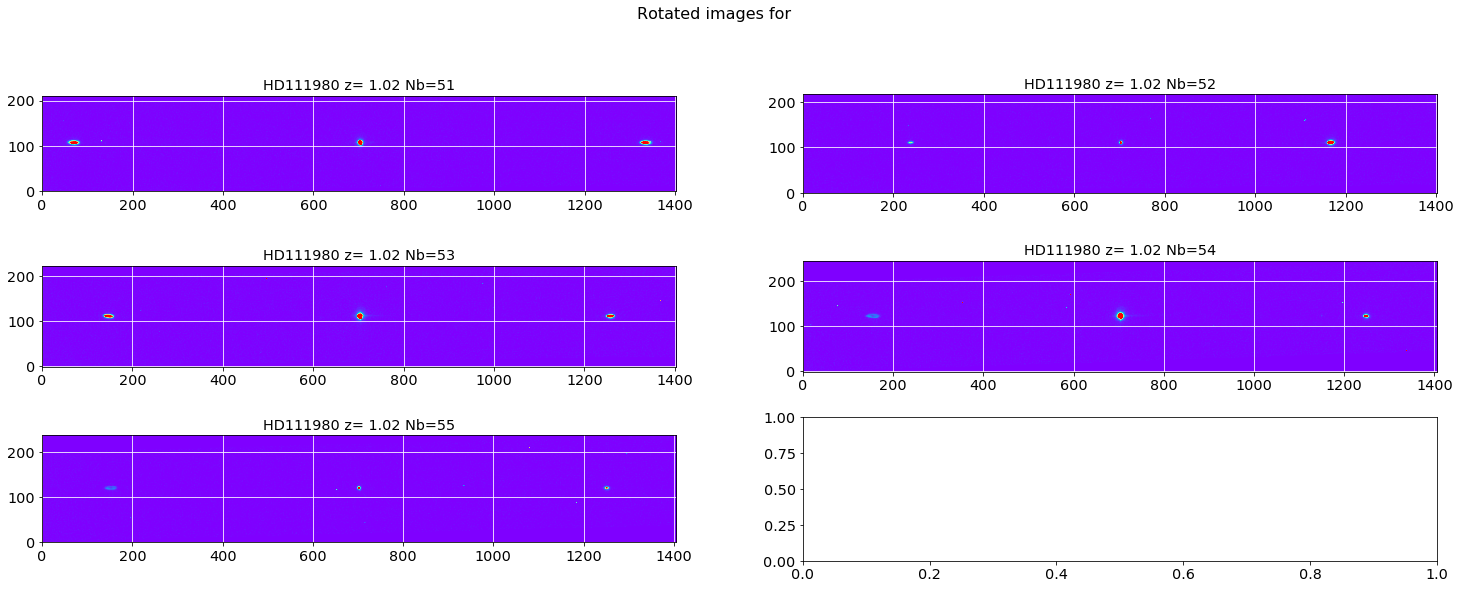

In [28]:
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,NBIMGPERROW=2) #same rotation for each image
figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
plt.savefig(figfilename)  

### Check rotation

In case of bad rotation, check by eye

array([-0.01267648, -0.00218085,  0.00373092,  0.00420552,  0.00460377])

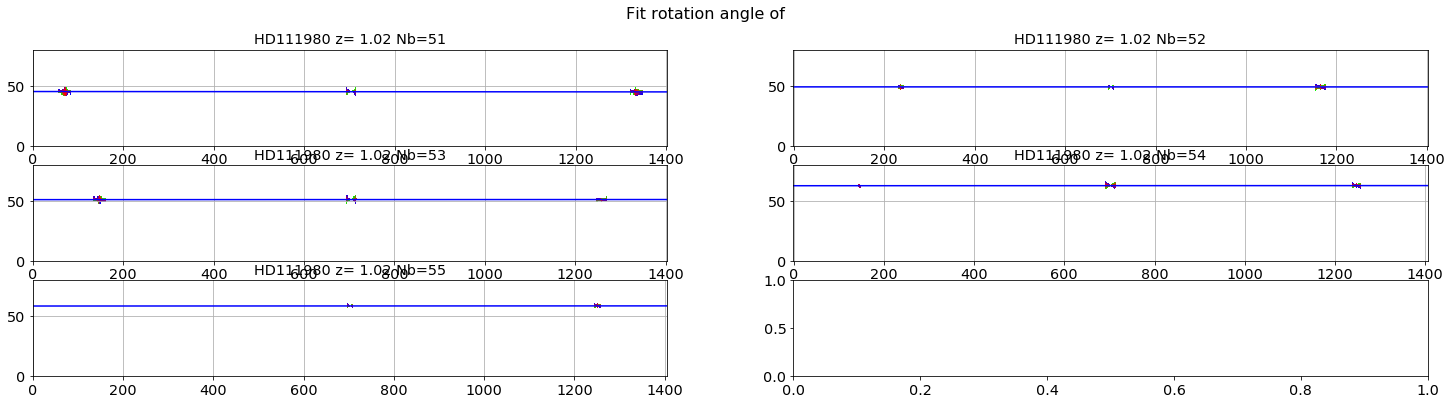

In [29]:
sel=4
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

ComputeRotationAngleHessianAndFit(turned_images,thex0,they0,all_titles,object_name, 
            NBIMGPERROW=2, lambda_threshold = -5, deg_threshold = 20, width_cut = 40, right_edge = 1600)

## Save results

In [30]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,f in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=turned_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(f,overwrite=True)
    
!ls -l rotated_fitsimages

total 25040
-rw-r--r--  1 jneveu  staff  2378880 26 jul 13:14 rotimg_20170531_051.fits
-rw-r--r--  1 jneveu  staff  2456640 26 jul 13:14 rotimg_20170531_052.fits
-rw-r--r--  1 jneveu  staff  2517120 26 jul 13:14 rotimg_20170531_053.fits
-rw-r--r--  1 jneveu  staff  2779200 26 jul 13:14 rotimg_20170531_054.fits
-rw-r--r--  1 jneveu  staff  2675520 26 jul 13:14 rotimg_20170531_055.fits
-rw-r--r--  1 jneveu  staff       52 26 jul 08:55 star_centroids.txt


XXXXXXXXXXXXX


AAATTTTENTION : LEs centres des étoiles ont bougés suite à la rotation : 
il faut les retrouver précisément ! (max ou ccdpoc) pour la suite (extraction du spectre)


XXXXXXXXXXX

In [31]:
positions_central2 = np.array([np.array(x_star) - x_mean + DeltaX, np.array(y_star) - y_mean + DeltaY]).T
print positions_central2
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central2,header="y_star x_star",fmt='%d')

[[ 701.04887807   99.67438674]
 [ 700.45247633  100.99792516]
 [ 700.59664138   99.70834464]
 [ 699.39977314   99.72347889]
 [ 698.50223107   99.89586457]]
./rotated_fitsimages/star_centroids.txt


# Extract spectra
===================================

In [32]:
outputdir="./spectrum_fitsspec"
ensure_dir(outputdir)

inputdir="./rotated_fitsimages"
SelectTagRe='^rotimg_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^rotimg_20170531_[0-9]+.fits$'

In [33]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


### Extraction

[106, 111, 112, 124, 119]

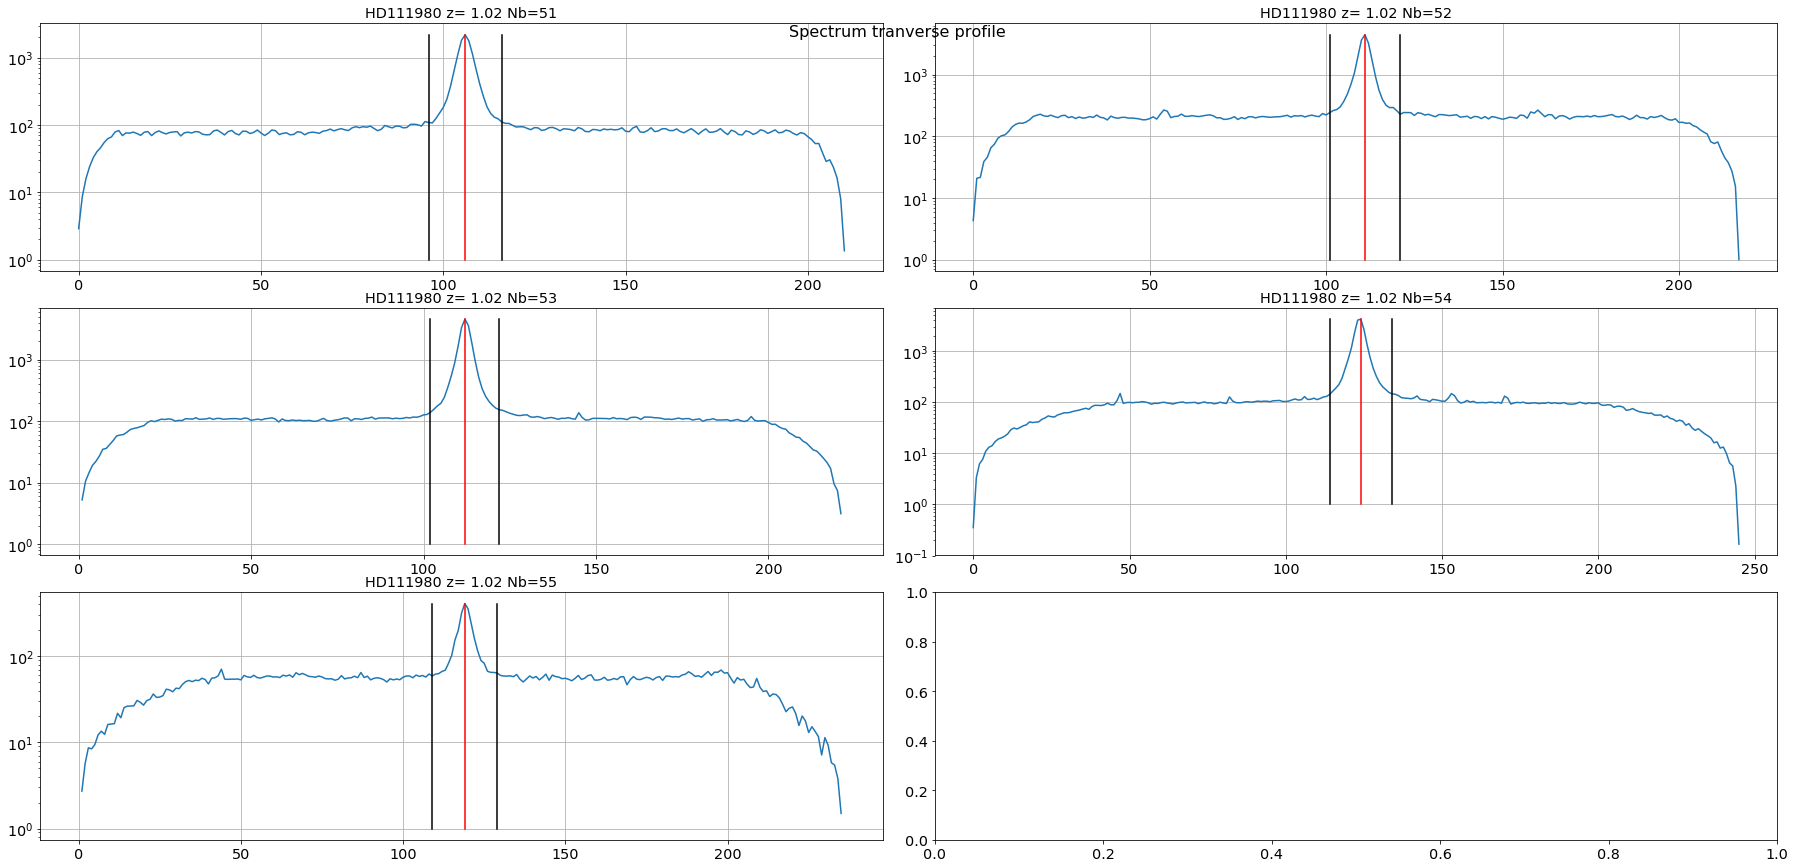

In [34]:
ShowTransverseProfile(all_images,all_titles,object_name,all_expo,NBIMGPERROW=2,DeltaX=1000,w=10,ws=80,right_edge=1800)

In [35]:
thespectra,thespectraUp,thespectraDown=ExtractSpectra(they0,all_images,all_titles,object_name,all_expo,
                                                      w=10,ws=80,right_edge=1800)

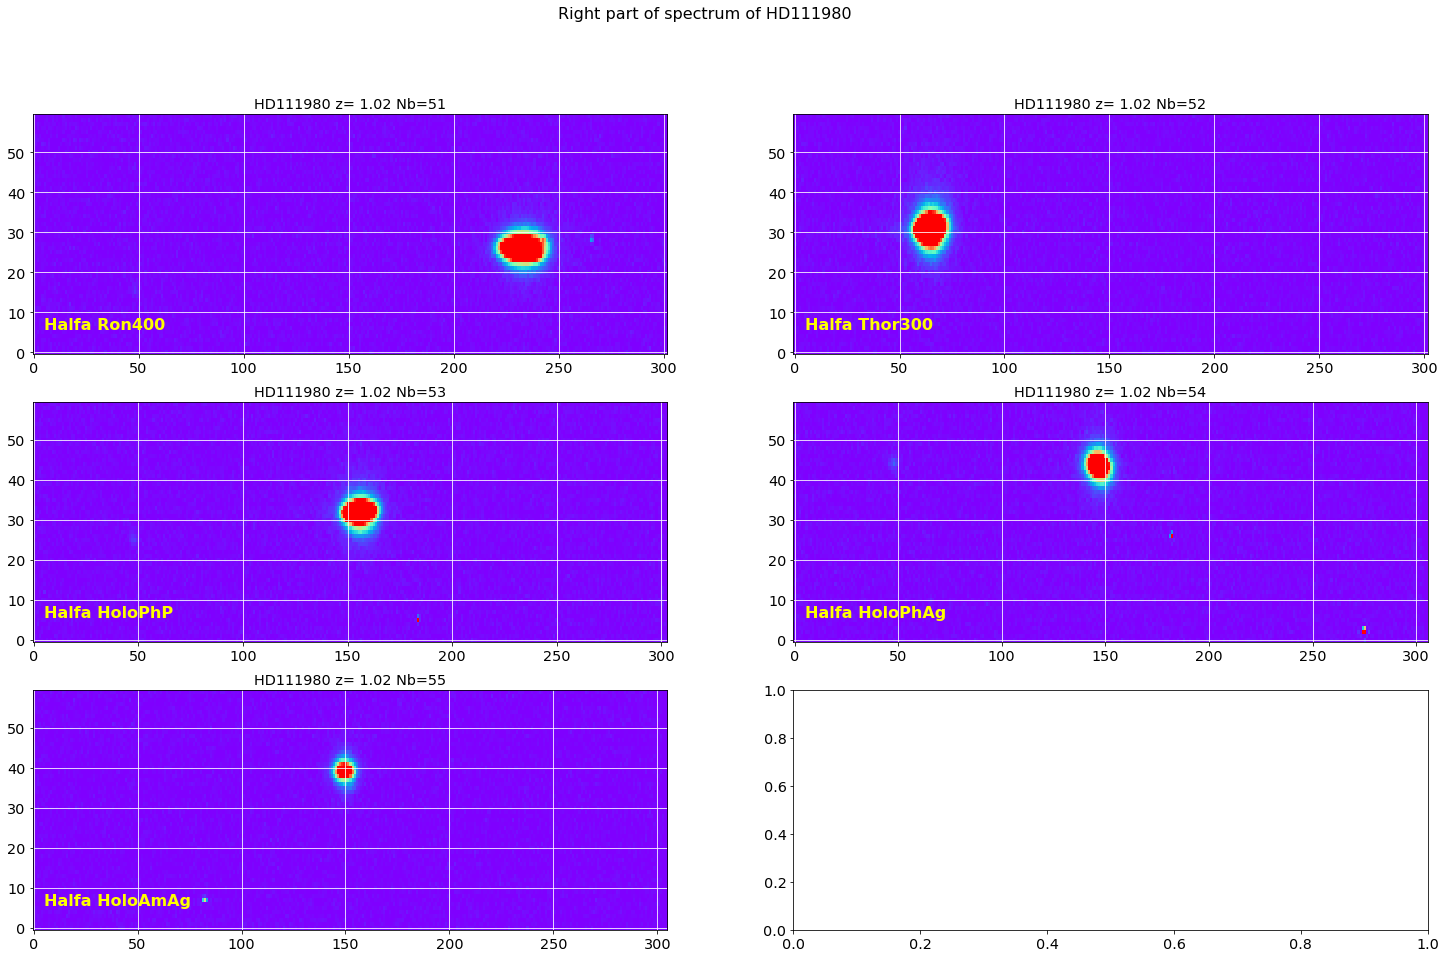

In [36]:
# Right spectrum
ShowCenterImages(1300,110,200,30,all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=500)
title='Right part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'rightorder.pdf')
plt.savefig(figfilename)  

In [37]:
# Left spectrum
ShowCenterImages(100,110,100,30,all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=500)
title='Left part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'leftorder.pdf')
plt.savefig(figfilename)  

In [38]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,all_filt,object_name,
                     NBIMGPERROW=2,right_edge=1800)
figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
plt.savefig(figfilename)   

(0, 20.0)

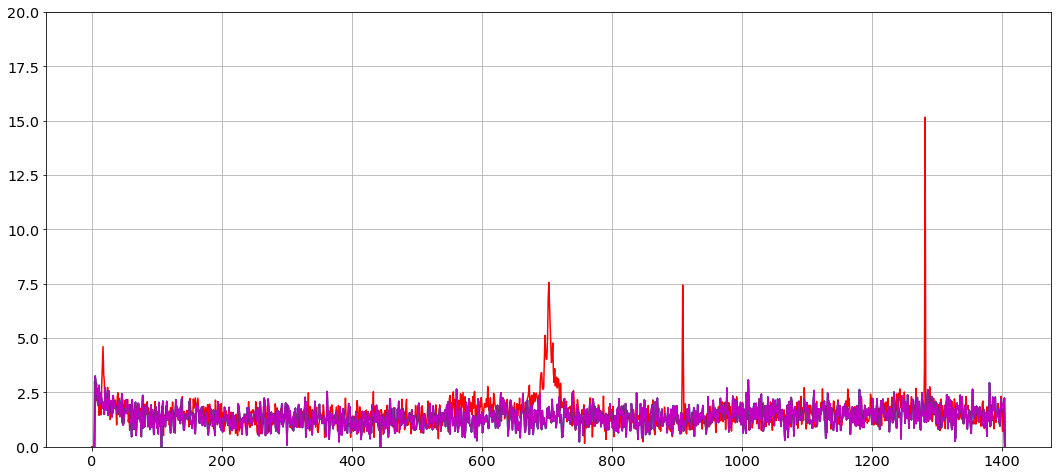

In [39]:
sel=3
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,20.)